# Part 1 - Data Preparation

In this notebook, we will try to find the best model that helps kMeans Bank decide whether to extend credit to a customer or not. You have seen this problem before when you were training kNN models. To find the best model, we will run and evaluate 6 different models. The 6 models are:
- Linear regression model
- Decision tree regressor
- kNN regression model
- Logistic regression model
- Decision tree classifier
- kNN classification model

We will start with importing the required packages. These include modules that are needed to handle and manipulate data, metrics that are used to evaluate models, and the models themselves.

**Note for Jupyter Notebook**: 

All the libraries/packages need to be updated to the latest version for the code to execute without any errors. Kindly check whether the *scikit-learn* library has been updated to the newest version, 1.1.

In [1]:
# Import numpy and pandas to work with numbers and dataframes
import pandas as pd
import numpy as np

# Import matplotlib.pyplot to create visualizations
from matplotlib import pyplot as plt

# Import libraries used in basic data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import GridSearchCV to perform cross validation
from sklearn.model_selection import GridSearchCV

# Import different metrics used to evaluate models
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import modules needed to train different models
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree

In [2]:
# Filter warnings
import warnings 
warnings.filterwarnings('ignore')

After importing the required libraries, we load the data and take a look at the first few rows of the data set. For this step, make sure that the CSV file is in the same folder as the notebook, or you have specified the complete address.

In [3]:
# Load the data and take a look at it
# Note: Make sure that the data is in the same folder as the Jupyter notebook or specify the address correctly
credit_df = pd.read_csv("MyCreditData.csv")
credit_df.head()

,checking_account,duration,credit_history,purpose,amount,savings_account,employment_duration,installment_rate,other_debtors,present_residence,...,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,gender,profit
0,3,18,0,2,1049,4,2,2,2,3,...,21,1,0,0,1,0,0,0,female,242
1,3,9,0,5,2799,4,0,1,2,0,...,36,1,0,1,1,1,0,0,male,596
2,0,12,4,8,841,0,1,1,2,3,...,23,1,0,0,3,0,0,0,female,25
3,3,12,0,5,2122,4,0,0,2,0,...,39,1,0,1,3,1,0,1,male,568
4,3,12,0,5,2171,4,0,2,2,3,...,38,0,2,1,3,0,0,1,male,782


We need to perform the following data manipulation steps before training models on the data:
- Convert categorical columns into the *categorical* data type
- Create a new binary column called *is_profitable* which will be used to train classification models
- Create separate input and output variables
- Create dummy variables in input variables
  - with the first column for regression models
  - without the first column for kNN and decision tree models
- Perform train-validation split on the input and output variables
- Scale non-dummy variables


In [4]:
# Ensure Python reads the categorical variables as categorical
non_categorical_columns = ['duration', 'amount', 'age', 'profit']
for column in credit_df.columns:
    if column not in non_categorical_columns:
        credit_df[column] = pd.Categorical(credit_df[column])

# Create binary dependent variable for classification models
credit_df["is_profitable"] = np.where(credit_df['profit'] > 0, 1, 0)

In [5]:
# Create separate variables for input and output 
y = credit_df['profit'] # Dependent variable for regression models
X = credit_df.iloc[:, :-2] # Independent variables: all columns but the last two: profit and is_profitable

# Use dummy variables for categorical variables 
X = pd.get_dummies(X, drop_first=False) #for kNN and trees
X2 = pd.get_dummies(X, drop_first=True) #for regression

# Perform the train validation split on all three data sets
X_train, X_val, X2_train, X2_val, y_train, y_val = train_test_split(X, X2, y, test_size=0.3, random_state = 1)

# Scale the non-dummy variables
scaler = StandardScaler()
X_train[['duration', 'amount', 'age']]= scaler.fit_transform(X_train[['duration', 'amount', 'age']])
X2_train[['duration', 'amount', 'age']]= scaler.transform(X2_train[['duration', 'amount', 'age']])

X_val[['duration', 'amount', 'age']]= scaler.transform(X_val[['duration', 'amount', 'age']])
X2_val[['duration', 'amount', 'age']]= scaler.transform(X2_val[['duration', 'amount', 'age']])

Recall that we don't drop the base value of the categorical variables for decision trees and kNN models. That is why we needed to create two input variables: X and X2.

Another thing to note here is that we need to fit the scaler only once as the mean and standard deviation as calculated on the training data are used to scale the validation data as well. Also, because the *duration*, *amount*, and *age* columns X_train and X_val are identical to those in X2_train and X2_val respectively, we can reuse the same scaler for all 4 data sets.

# Part 2 - Model Selection

Now that we have performed data manipulation required to train the models, we will select the best model based on two criteria:
- Statistical measures
- Business impact

First, we will evaluate the prediction (regression) models based on the statistical measure of root mean squared error. For that, we need to define a function that calculates the RMSE, given the training and predicted outputs.

In [6]:
# Define a function to calculate RMSE
def rmse(y_train, y_pred):
  return np.sqrt(mean_squared_error(y_train, y_pred))

## 2.1 Fitting and evaluating prediction models using statistical measures

In this section, we will train the three prediction models and evaluate them using the statistical measure of RMSE. We will start by training and evaluating a linear regression model with lasso regularization. For that, we will need to find the optimal value of alpha using the *LassoCV()* function. Note that this is a linear regression model, hence we will use X2_train to train the model.

In [7]:
# Check all alphas from .01 to 10 in steps of size 0.25
alphas = np.arange(.01, 25, .25)
lasso_cv_model = LassoCV(alphas= alphas, cv=5, max_iter=50000)
lasso_cv_model.fit(X2_train, y_train)

# Train the lasso regression model with the best value of alpha
lin_reg_best = Lasso(alpha=lasso_cv_model.alpha_)
lin_reg_best.fit(X2_train, y_train)

# Calculate RMSE for the lasso regression model on train and validation sets
lin_train_rmse = rmse(y_train, lin_reg_best.predict(X2_train))
lin_val_rmse = rmse(y_val, lin_reg_best.predict(X2_val))

After training the linear regression model with the optimal value of alpha, we have calculated the value of RMSE over the training and validation data using the *rmse()* function that we defined earlier. 

Next, we will train a decision tree regressor. But here again, we need to find the optimal value for the *ccp_alpha* parameter. So we will train multiple decision tree regressors and using different values of ccp alpha that we obtain using the *cost_complexity_pruning_path()* function.

In [8]:
# Get the different values of ccp alphas
tree_reg = DecisionTreeRegressor()
path= tree_reg.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas = path.ccp_alphas

# Train decision tree regressor models for different values of ccp_alpha

# Create a list to store the different tree models
regs=[]

# Iterate through different ccp alpha values and train models for each of them
for ccp_alpha in ccp_alphas:
  # Create and train the model
  curr_reg = DecisionTreeRegressor(random_state=0, ccp_alpha = ccp_alpha)
  curr_reg.fit(X_train,y_train)

  # Save the model in the list
  regs.append(curr_reg)

# Calculate the RMSE for all the tree models

# Create lists to store RMSE on training and validation data sets
train_rmse=[]
val_rmse=[]

# Iterate through the models and calculate RMSE
for r in regs:
  y_train_pred=r.predict(X_train)
  y_val_pred = r.predict(X_val)

  train_rmse.append(rmse(y_train_pred,y_train))
  val_rmse.append(rmse(y_val_pred,y_val))

# Pick the best ccp alpha
best_ccp_alpha = ccp_alphas[val_rmse.index(min(val_rmse))]

# Train the corresponding tree
tree_reg_best = tree.DecisionTreeRegressor(random_state=0, ccp_alpha=best_ccp_alpha)
tree_reg_best.fit(X_train,y_train)

# Calculate RMSE for the best tree
tree_train_rmse = rmse(y_train, tree_reg_best.predict(X_train))
tree_val_rmse = rmse(y_val, tree_reg_best.predict(X_val))

We have now trained a decision tree regressor model using the value of ccp alpha that minimizes the RMSE on the validation data set. Then we trained a tree using that value of ccp alpha and calculated its RMSE over the training and validation data sets.

Next, we will train a kNN regression model, but instead of performing hyperparameter tuning as we have done in the previous two cases, we can simply use the optimal value *n_neighbors=16* that we calculated earlier.

In [9]:
# KNN Model (using our previous knowledge about the best k!)
knn_reg_best = KNeighborsRegressor(n_neighbors=16)
knn_reg_best.fit(X_train, y_train)

knn_train_rmse = rmse(y_train, knn_reg_best.predict(X_train))
knn_val_rmse = rmse(y_val, knn_reg_best.predict(X_val))

Finally, after training the three models and calculating their RMSE on the trianing and validation data sets, we will arrange them in a dataframe to display them properly in a table.

In [10]:
# Create a dataframe to display the RMSE values for the three models
pd.DataFrame([[lin_train_rmse, lin_val_rmse],[tree_train_rmse, tree_val_rmse], 
              [knn_train_rmse, knn_val_rmse]], columns=['RMSE Train', 'RMSE Validation'], 
              index = ['Linear', 'Tree', 'kNN'])

,RMSE Train,RMSE Validation
Linear,1062.634646,1131.096301
Tree,1112.240830,1096.454554
kNN,1041.998782,1195.489711


From this table, we can see that although the decision tree model had the worst performance (highest RMSE) on the training data, its performance is best (lowest RMSE) among the three models on the validation data set.

Next, we will train and evaluate classification models.

## 2.2 Model selection for classification using statistical measures

So far, we have trained and evaluated the three regression models. Now, we will train the three classification models and evaluate them based on their validation accuracy. 

Note that we first need to change the independent variable in the training and validation data set. Recall that we created a binary variable in the column *is_profitable*. That is the column that we will use as the independent variable while training classification models. As we are creating a new independent variable, we need to perform a train validation split again. But remember to use the same value for the *random_state* parameter, otherwise the input and output values may not match.

In [11]:
# Create the variable for output in case of classification
y = credit_df['is_profitable']

# Perform train-validation split on the new independent variable
y_train, y_val = train_test_split(y, test_size=0.3, random_state = 1)

After preparing the independent variable, we need to train the three classification models. This time, we will use the optimal hyperparameters for all three models using our knowledge from previous modules. Therefore, the value of the *solver* and *max_iter* parameters in *LogisticRegression()*, the value of *ccp_alpha* in *DecisionTreeClassifier()*, and the value of *n_neighbors* in *KNeighborsClassifier()* are obtained from our previous analysis.

Finally, after training the models, we will evaluate them using validation accuracy and training accuracy and store those values in a dataframe.

In [12]:
# Create and train the logistic regression model
log_clf_best = LogisticRegression(penalty='none', solver='lbfgs', random_state=0, 
                                     max_iter=200).fit(X2_train, y_train)

# Calculate the logistic regression model's accuracy on the training and validation sets
log_train_acc = log_clf_best.score(X2_train, y_train)
log_val_acc = log_clf_best.score(X2_val, y_val)

# Create and train the decision tree classifier model
best_ccp_alpha = 0.004801587301587302 # from Module 4
tree_clf_best = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)
tree_clf_best.fit(X_train,y_train)

# Calculate the decision tree classifier model's accuracy on the training and validation sets
tree_train_acc = tree_clf_best.score(X_train, y_train)
tree_val_acc = tree_clf_best.score(X_val, y_val)

# Create and train the kNN model
knn_clf_best = KNeighborsClassifier(n_neighbors=14)
knn_clf_best.fit(X_train, y_train)

# Calculate the kNN model's accuracy on the training and validation sets
knn_train_acc = knn_clf_best.score(X_train, y_train)
knn_val_acc = knn_clf_best.score(X_val, y_val)

# Create a dataframe to display the accuracy values for the three models
pd.DataFrame([[log_train_acc, log_val_acc], [tree_train_acc, tree_val_acc], 
              [knn_train_acc, knn_val_acc]], columns=['Training Acc', 'Validation Acc'], 
              index = ['Logistic', 'Tree', 'kNN'])

,Training Acc,Validation Acc
Logistic,0.787143,0.766667
Tree,0.792857,0.726667
kNN,0.790000,0.730000


You can see that the logistic regression model has the best validation accuracy. Also, the performance of the models doesn't vary greatly between the training and validation data sets.

We have now evaluated all 6 models on the basis of statistical measures such as RMSE and accuracy. But this kind of analysis may not necessarily result in the best results according to the business' bottom line. Hence, the next analysis we perform will be on the basis of the profit that different models earn for the business.

## 2.3 Best credit model according to business impact

We will now find the model that is best according to its business impact, that is, on the basis of the amount of profit it can earn for the business. Let's first look at how we will do this for classification models.

As the output of the classification models is the probability of a customer being profitable, we need to decide a cutoff probability beyond which we will extend credit. In other words, if we select a cutoff probability of 0.6, we will extend credit to all the customers whose probability of being profitable is greater than 0.6.

We will choose the best cutoff probability for each model that maximizes the profit earned by the bank on the validation data set. Once we have calculated the best cutoff probability and hence the highest profit on the validation data set for all three models, we can choose the model that produces the highest profit.

Let's take this step by step.

In [13]:
# Set potential cutoff values
clf_cutoffs = np.arange(0,1.01,0.01)

# Recover profit for training and testing data
profit_arr = np.array(credit_df['profit'])
profit_train, profit_val = train_test_split(profit_arr, test_size=0.3, random_state = 1)

# For each model obtain the predicted probabilities and then save the total profit for different cutoffs
table = []
for clf_model in [log_clf_best, tree_clf_best, knn_clf_best]:
    
    # In case of logistic regression, use X2
    if clf_model == log_clf_best:
      probs_train = clf_model.predict_proba(X2_train)[:, 1]
      probs_val = clf_model.predict_proba(X2_val)[:, 1]
    
    # In case of decision tree or kNN, use X
    else:
      probs_train = clf_model.predict_proba(X_train)[:, 1]
      probs_val = clf_model.predict_proba(X_val)[:, 1]
    
    # Add the profits for all models which satisfy the cutoff for different values of cutoff
    clf_profits = []
    for cutoff in clf_cutoffs:
        clf_profits.append(sum(profit_train[probs_train > cutoff]))

    # Calculating the best cutoff
    best_profit_train = max(clf_profits)
    best_cutoff = clf_cutoffs[clf_profits.index(best_profit_train)]
    best_profit_val = sum(profit_val[probs_val > best_cutoff])
    table.append([best_cutoff, best_profit_train, best_profit_val])

You can see that we first created a list of cutoffs called *clf_cutoffs*. We then iterated through the three models calculating their best cutoff value (the value that maximizes profit on the validation data set). Finally, we have appended the cutoff, profit on the train data set, and the profit on the validation data set in a table.

After calculating these values for the classification models, we will repeat the same process for the regression models, except, this time we will use different values of profit instead of probabilities as cutoff.

In [14]:
# Set potential cutoff values
reg_cutoffs = np.arange(-5000, 2000)

# For each model obtain the predicted profit and then save the total profit for different cutoffs
for reg_model in [lin_reg_best, tree_reg_best, knn_reg_best]:
    
    # In case of linear regression, use X2
    if reg_model == lin_reg_best:
      pred_train = reg_model.predict(X2_train) 
      pred_val = reg_model.predict(X2_val)
    
    # In case of decision tree or kNN, use X
    else:
      pred_train = reg_model.predict(X_train) 
      pred_val = reg_model.predict(X_val)

    # Add the profits for all models which satisfy the cutoff for different values of cutoff     
    reg_profits = []
    for cutoff in reg_cutoffs:
        reg_profits.append(sum(profit_train[pred_train > cutoff]))

    # Calculating the best cutoff
    best_profit_train = max(reg_profits)
    best_cutoff = reg_cutoffs[reg_profits.index(best_profit_train)]
    best_profit_val = sum(profit_val[pred_val > best_cutoff])
    table.append([best_cutoff, best_profit_train, best_profit_val])

To view the results of this analysis, we will arrange the values in a dataframe *table_df* and display it.



In [15]:
table_df = pd.DataFrame(table, columns=['Cutoff Value', 'Train Profit', 'Validation Profit'], 
                        index=['Logistic Clf','Tree Clf','KNN Clf','Linear Reg',' Tree Reg', 'KNN Reg'])
table_df

,Cutoff Value,Train Profit,Validation Profit
Logistic Clf,0.62,135590,51690
Tree Clf,0.32,113807,33949
KNN Clf,0.65,124283,35622
Linear Reg,-292.00,115896,34703
Tree Reg,-2715.00,49394,18923
KNN Reg,23.00,133572,35107


We can see that the logistic regression model with a cutoff value 0.62 maximizes the profit at $51,690.

## 2.4 How does cutoff influence profit?

We also want to understand how profit varies with cutoff values. For this, in case of classification model, we can calculate the total profit on the training and validation data sets for each cutoff value and plot it against the cutoff value. 

Let's do this for the kNN model first. Similar analysis can be repeated for the other models.

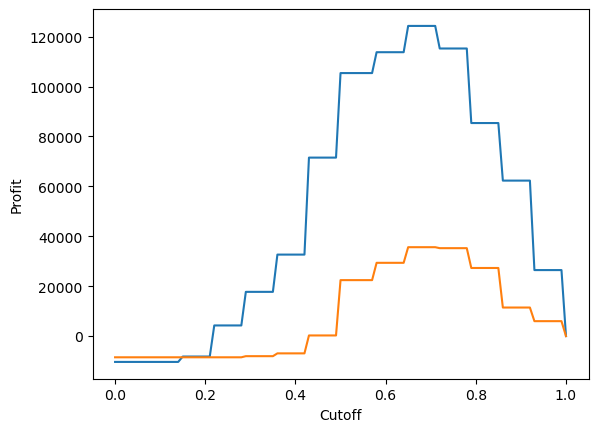

In [16]:
# Calculate the predicted probability using the best kNN model on the training and validation data sets
probs_train = knn_clf_best.predict_proba(X_train)[:, 1]
probs_val = knn_clf_best.predict_proba(X_val)[:, 1]

# Saving profits for different cutoffs
train_profits_by_cutoff, val_profits_by_cutoff = [], []
for cutoff in clf_cutoffs:
    train_profits_by_cutoff.append(sum(profit_train[probs_train > cutoff]))
    val_profits_by_cutoff.append(sum(profit_val[probs_val > cutoff]))

# Plotting training and validation profts against cutoffs 
plt.plot(clf_cutoffs, train_profits_by_cutoff)
plt.plot(clf_cutoffs, val_profits_by_cutoff)
plt.xlabel('Cutoff')
plt.ylabel('Profit')
plt.show()

We can see the profit is maximized at similar cutoffs for train and validation. But is that true for all the models? For that, we will have to plot the best cutoff based on the training data along with the cutoff vs profit on validation data. That is what we will do next.

## 2.5 Comparing best cutoff on training data with profit on validation data for classification models

So now we want to check whether the best cutoff that we calculated using the training data is close to the cutoff value that maximizes profit on the validation data. 

We already know the best cutoff values on the training data, so we will represent them using vertical lines with different colors for different models. While on the same graph, we will plot the total profit on the validation data set for each cutoff value. 

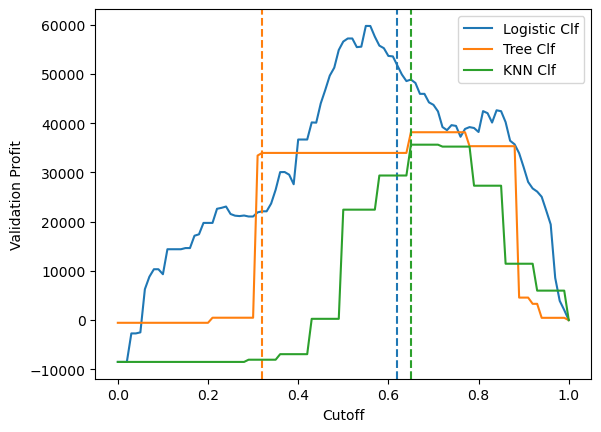

In [17]:
# Create a list to specify colors for the three different models
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create cutoff vs validation profit graphs along with the best train cutoff value for the three classification models
for i, clf_model in enumerate([log_clf_best, tree_clf_best, knn_clf_best]):
    
    # In case of logistic regression, use X2
    if i==1:
      probs_val = clf_model.predict_proba(X2_val)[:, 1]
    
    # In case of decision tree or kNN, use X
    else:
      probs_val = clf_model.predict_proba(X_val)[:, 1]
    
    # Create a list of total profit values for different cutoff values
    val_profits_by_cutoff = []
    for cutoff in clf_cutoffs:
        val_profits_by_cutoff.append(sum(profit_val[probs_val > cutoff]))
    
    # Get the name of the classification model
    model_name = table_df.index[i]
    
    # Add the current model's validation profit to the plot
    plt.plot(clf_cutoffs, val_profits_by_cutoff, label=model_name, color=colors[i])
    
    # Add the current model's best train cutoff to the plot
    best_train_cutoff = table_df['Cutoff Value'][i]
    plt.axvline(x=best_train_cutoff, color=colors[i], linestyle='dashed')
plt.xlabel('Cutoff')
plt.ylabel('Validation Profit')
plt.legend()

You can see that the optimal cutoff value obtained using the train data (represented by the vertical lines) is close to the optimal cutoff value that we observe using the validation data (represented by the point where the graph achieves the maximum value) for all three models.

We can generate the same plot for the prediction models.

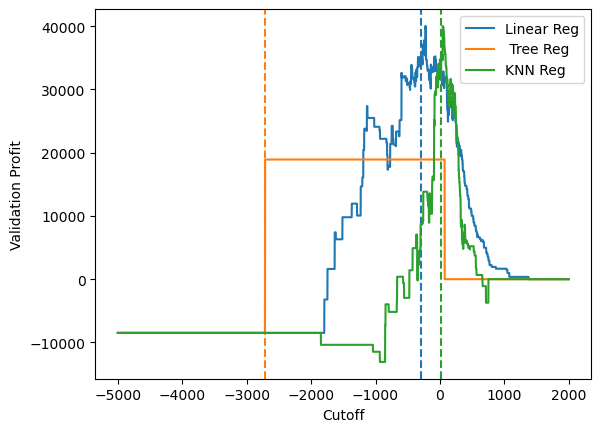

In [18]:
# Create a list to specify colors for the three different models
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Create cutoff vs validation profit graphs along with the best train cutoff value for the three regression models
for i, reg_model in enumerate([lin_reg_best, tree_reg_best, knn_reg_best]):

    # In case of linear regression, use X2
    if i==1:
      pred_val = reg_model.predict(X2_val)
    
    # In case of regression tree and kNN, use X
    else:
      pred_val = reg_model.predict(X_val)

    # Create a list of total profit values for different cutoff values
    val_profits_by_cutoff = []
    for cutoff in reg_cutoffs:
        val_profits_by_cutoff.append(sum(profit_val[pred_val > cutoff]))
    
    # Get the name of the regression model
    model_name = table_df.index[i+3]

    # Add the current model's validation profit to the plot
    plt.plot(reg_cutoffs, val_profits_by_cutoff, label=model_name, color=colors[i])
    
    # Add the current model's best train cutoff to the plot
    train_cutoff = table_df['Cutoff Value'][i+3]
    plt.axvline(x=train_cutoff, color=colors[i],linestyle='dashed')
plt.xlabel('Cutoff')
plt.ylabel('Validation Profit')
plt.legend()


Here again, you can see that the optimal cutoff value obtained using the train data (represented by the vertical lines) is close to the optimal cutoff value that we observe using the validation data (represented by the point where the graph achieves the maximum value) for all three models.